# Disparate Impact Remover: Preprocessing for Fairness

The Disparate Impact Remover is a preprocessing technique that transforms feature values to increase group fairness while preserving as much data utility as possible.

This demo shows how to use the Disparate Impact Remover to mitigate bias in a dataset and evaluate its effect on fairness metrics.

Key features:
- **Preprocessing approach**: Adjusts features before model training
- **Tunable repair level**: Controls the trade-off between fairness and data utility
- **Works with any downstream model**: Model-agnostic

We'll use the Adult dataset and focus on the 'sex' attribute as the sensitive feature.

In [17]:
import sys
import os
# Add the root directory of the project to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('..')))


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import openml

from fairlib import DataFrame
from fairlib.preprocessing import DisparateImpactRemover
from fairlib.metrics import statistical_parity_difference, disparate_impact

np.random.seed(42)


## Loading and Preparing the Adult Dataset
We use the Adult dataset from OpenML. The sensitive attribute is 'sex'.

In [29]:
TARGET = "income"
SENSITIVE = "sex"

# Load the Adult dataset
adult_dataset = openml.datasets.get_dataset(179)
adult_X, _, _, _ = adult_dataset.get_data(dataset_format="dataframe")
adult_X.rename(columns={'class': 'income'}, inplace=True)
adult = DataFrame(adult_X)
adult.targets = TARGET
adult.sensitive = SENSITIVE
adult.drop(columns=["fnlwgt"], inplace=True)
label_maps = {}
for col in adult.columns:
    if adult[col].dtype == 'object' or adult[col].dtype == 'category':
        adult[col], uniques = pd.factorize(adult[col])
        label_maps[col] = uniques

print(f"Mapping for 'sex': {dict(enumerate(label_maps['sex']))}")
print(f"Dataset shape: {adult.shape}")
print(f"Target column: {adult.targets}")
print(f"Sensitive attributes: {adult.sensitive}")
adult.head()


Mapping for 'sex': {0: 'Male', 1: 'Female'}
Dataset shape: (48842, 14)
Target column: {'income'}
Sensitive attributes: {'sex'}


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,income
0,0,0,0,13,0,0,0,0,0,0,0,0,0,0
1,1,1,0,13,1,1,1,0,0,1,0,1,0,0
2,0,2,1,9,2,2,0,0,0,1,0,0,0,0
3,1,2,2,7,1,2,1,1,0,1,0,0,0,0
4,2,2,0,13,1,3,2,1,1,1,0,0,1,0


## Applying the Disparate Impact Remover
We apply the Disparate Impact Remover at different repair levels to see its effect on fairness.

In [21]:
# Split data into features and target
adult = adult[:1000]

X = adult.drop(columns=[TARGET])
y = adult[TARGET]
sensitive = adult[SENSITIVE]

# Split into train and test
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42, stratify=y
)


# Example repair levels
repair_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
results = []

# Create DataFrames with proper metadata
X_train_df = DataFrame(X_train)
X_train_df.sensitive = SENSITIVE

X_test_df = DataFrame(X_test)
X_test_df.sensitive = SENSITIVE

for repair_level in repair_levels:
    # Initialize the DisparateImpactRemover with the current repair level
    dir_remover = DisparateImpactRemover(repair_level=repair_level)

    # Apply fit_transform on training data (no need to pass s_train)
    X_train_repaired = dir_remover.fit_transform(X_train_df)

    # Apply fit_transform on test data (no need to pass s_test)
    # Note: DisparateImpactRemover doesn't have a separate transform method for DataFrames
    X_test_repaired = dir_remover.fit_transform(X_test_df)

    # Train a simple classifier
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train_repaired, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_repaired)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)

    # Extract sensitive attribute from DataFrame metadata
    s_test_values = X_test_df[SENSITIVE].values

    # Calculate fairness metrics using the extracted sensitive attribute
    spd = statistical_parity_difference(y_pred, s_test_values)
    di = disparate_impact(y_pred, s_test_values)

    # Store results
    results.append({"repair_level": repair_level, "accuracy": acc, "SPD": spd, "DI": di})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

   repair_level  accuracy                                                SPD  \
0          0.00  0.818058  [[-0.17485535150549236, 0.1748553515054924], [...   
1          0.25  0.801406  [[-0.05070152618930279, 0.050701526189302834],...   
2          0.50  0.800450  [[-0.05059267321514127, 0.05059267321514126], ...   
3          0.75  0.805159  [[-0.0766899596573456, 0.07668995965734564], [...   
4          1.00  0.793967  [[-0.06648671145618745, 0.06648671145618751], ...   

                                                  DI  
0  [[1.2183673296892603, 0.12247850399099276], [0...  
1  [[1.0588706092998272, 0.6346187572323817], [0....  
2  [[1.0586952176385385, 0.6335042660546018], [0....  
3  [[1.0907344084607993, 0.504543167071057], [0.9...  
4  [[1.0774114593084718, 0.5288830984443657], [0....  


## Visualizing the Fairness-Accuracy Trade-off
Let's plot how accuracy and fairness metrics change with different repair levels.

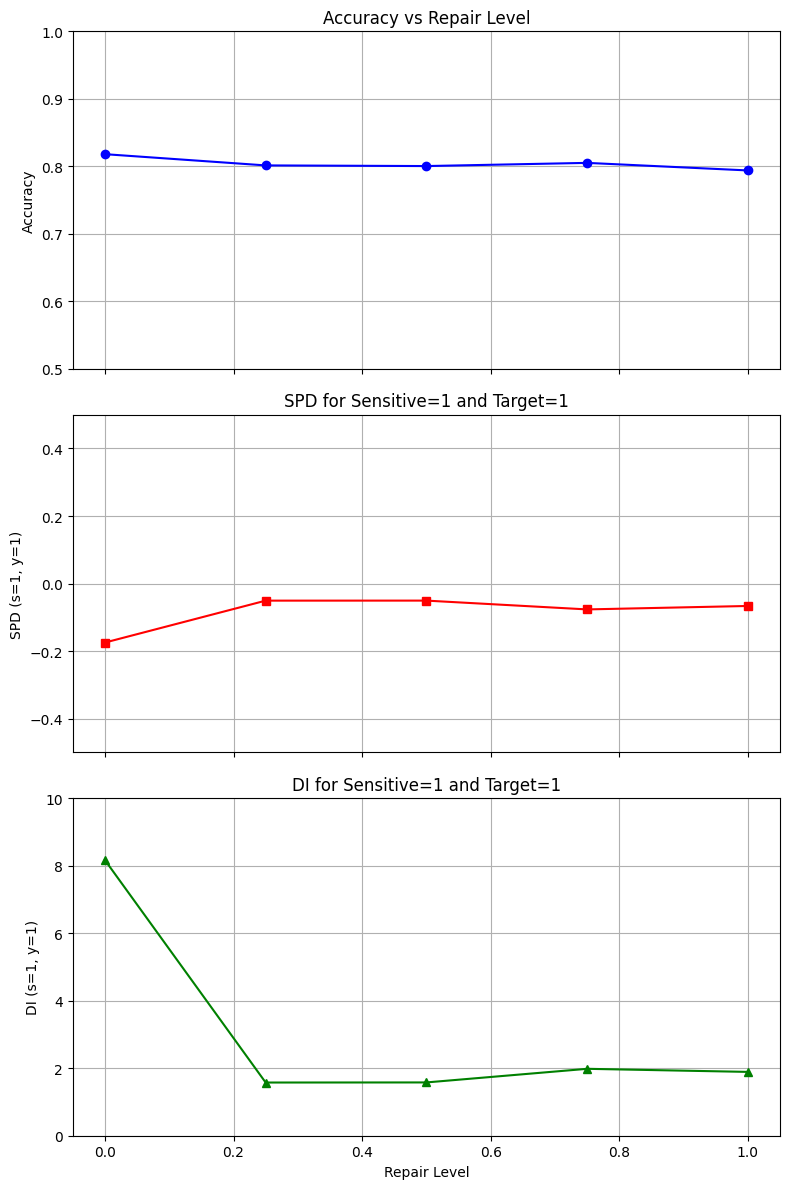

In [31]:
results_df['SPD_11'] = results_df['SPD'].apply(lambda x: x[1][1])
results_df['DI_11'] = results_df['DI'].apply(lambda x: x[1][1])

# Imposta figure con 3 subplot verticali
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# --- Accuracy ---
axes[0].plot(results_df['repair_level'], results_df['accuracy'], 'o-', color='blue')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Repair Level')
axes[0].grid(True)
axes[0].set_ylim(0.5, 1.0)

# --- SPD [1][1] ---
axes[1].plot(results_df['repair_level'], results_df['SPD_11'], 's-', color='red')
axes[1].set_ylabel('SPD (s=1, y=1)')
axes[1].set_title('SPD for Sensitive=1 and Target=1')
axes[1].grid(True)
axes[1].set_ylim(-0.5, 0.5)

# --- DI [1][1] ---
axes[2].plot(results_df['repair_level'], results_df['DI_11'], '^-', color='green')
axes[2].set_ylabel('DI (s=1, y=1)')
axes[2].set_title('DI for Sensitive=1 and Target=1')
axes[2].set_xlabel('Repair Level')
axes[2].grid(True)
axes[2].set_ylim(0, 10)

plt.tight_layout()
plt.show()
